# Chapter 2: Taking Earth's Temperature

### Part I: It’s getting hot(ter) in here: Long-Term Development of Global Earth Temperature Since 1850

Imagine a doctor’s thermometer, but one that’s designed to gauge the health of our planet. As a fever reveals a person’s illness, Earth’s rising temperature exposes a global condition that’s equally concerning. This chapter, much like a medical investigation, unfolds the diagnosis of Earth’s thermal well-being.

The previous chapter delved into the enigmatic world of greenhouse gases (GHGs), namely carbon dioxide and methane, elucidating how their concentrations are increasing in our atmosphere. Now, we turn our lens to scrutinise the surface temperature of our Earth, which is also on the rise, a tell-tale symptom of increasing GHGs.

We have divided this chapter into three notebooks, each focusing on a distinctive aspect:

1. Long-Term Development of Global Earth Temperature Since 1850 ([this notebook](#part-one))
2. Comparing Reanalysis with Observations since 1950
3. Visualising Recent Temperature Anomalies

<div class="alert alert-block alert-success">
<b>Objective:</b> <br>
    Our aim here is to perform a historical examination, comparing the global surface temperature from 1850-2022 using various authoritative data sources. We will stitch together a monthly resolved time series that paints the average surface anomaly over the past ~250 years. The grand finale? A common plot that showcases these time series. </a>
</div>

Here's an overview of the datasets we'll employ:

| Dataset | Spatial Coverage | Spatial Resolution | Temporal Coverage | Temporal resolution |Provider |
|---------|:-------------:|:------:|:------:|:------:|:------:|
|  [NOAAGlobalTempv5](https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp) |  Global | 5º x 5º | 1850 - today | Monthly | NOAA |
|  [Berkeley Earth](https://berkeleyearth.org/data/) |  Global | 1º x 1º | 1850 - today | Monthly | Berkeley Earth |
|  [GISTEMPv4](https://data.giss.nasa.gov/gistemp/) |  Global | 2º x 2º | 1880 - today | Monthly | NASA |
|  [HadCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/) |  Global | 5º x 5º | 1850 - today | Monthly | Met Office Hadley Centre |
|  [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) |  Global | 0.25º x 0.25º | 1940 - today | Monthly | C3S/ECMWF |

Additionally, we'll wield the land-sea mask created by the respective provider to weight the datasets accurately.

**Here's what to expect:**

- **Downloading, opening, and streamlining datasets**: From providers as diverse as the climate they track.
- **Handling moderate data volumes** (~ 5 GB): No worries, [`dask`](https://www.dask.org/) will take care of the work.
- **Calculating spatially and temporally correct averages**: Like taking Earth's temperature, but with mathematics.
- **Estimating uncertainties**: A vital step in this scientific expedition, achieved through ensemble members.

<div class="alert alert-block alert-info">    
<b>NOTE</b>: 
Before interacting with the following notebook, please ensure you've reviewed the <a href="https://ecmwfcode4earth.github.io/sketchbook-earth/how_to_run_notebooks.html">How to Execute the Notebooks</a> section.
</div>

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/02_temperature/02a_temperature.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/02_temperature/02a_temperature.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/02_temperature/02a_temperature.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

--------------

#### Getting Set Up: Your Toolkit

Prepare for our planetary health check by importing all necessary packages:

In [1]:
# Python Standard Libraries
import os
import zipfile
import urllib.request

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import regionmask as rm
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi

The following cell ensures a consistent figure layout. If you’re running this notebook on one of the cloud platforms, the stylesheet may not be present by default. In this case you can either upload the file or ignore the following cell. It’s about styling, and while it won’t affect your calculations, aesthetics matter, don’t they?

In [2]:
plt.style.use("../copernicus.mplstyle")

Additionally, we instruct dask to avoid the creation of large chunks that may arise in different calculations.

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

With the `regionmask` package, you'll craft a land-sea mask for any `xr.DataArray`, something you'll need later if our chosen data provider doesn't offer additional weights.

In [4]:
# Boolean land-sea mask
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

Here's where your creativity shines. Define the `REGIONS` that captivate your curiosity. Since the data sets (except ERA5) are relatively coarse, make your regions generous enough to ensure sufficient data. While we followed the definitions used in the [C3S Climate Intelligence reports](https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions), feel free to change them or to add your own regions of interest! Your playground is as vast as the planet itself:

In [5]:
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
}

This is the stage where you pick your time frame for defining the period used as climatology. For instance, you could use the currently valid period of 1991-2020.

In [6]:
REF_PERIOD = {"time": slice("1991", "2020")}

Since we are tapping into different data sources that all come in their format and peculiarities, let's organize the data in folders for a better overview.

In [7]:
file_name = {}  # dictionary containing [data source : file name]

# Berkeley Earth
file_name.update({"berkeley": "temperature_berkeley.nc"})  

# GISTEMP
file_name.update({"gistemp_250km": "temperature_gistemp_250km.gz"})  # higher resolution
file_name.update({"gistemp_1200km": "temperature_gistemp_1200km.gz"})  # lower resolution
file_name.update({"gistemp_lsm": "temperature_gistemp_lsm.txt"})  # land sea mask

# HadCRUT
file_name.update({"hadcrut": "temperature_hadcrut.nc"})
file_name.update({"hadcrut_lsm": "temperature_hadcrut_lsm.nc"})  # land sea mask
file_name.update({"hadcrut_members": "temperature_hadcrut_ensemble_members.zip"})  # ensemble members

# ERA5
file_name.update({"era5": "temperature_era5.nc"})

# Create the paths to the files
path_to = {}
for source, file in file_name.items():
    root = "data/{:}/".format(source.split("_")[0])
    path_to.update({source: os.path.join(root, file)})

Create necessary directories if they don't exist:

In [8]:
for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<15} --> {}".format(file, path))

berkeley        --> data/berkeley/temperature_berkeley.nc
gistemp_250km   --> data/gistemp/temperature_gistemp_250km.gz
gistemp_1200km  --> data/gistemp/temperature_gistemp_1200km.gz
gistemp_lsm     --> data/gistemp/temperature_gistemp_lsm.txt
hadcrut         --> data/hadcrut/temperature_hadcrut.nc
hadcrut_lsm     --> data/hadcrut/temperature_hadcrut_lsm.nc
hadcrut_members --> data/hadcrut/temperature_hadcrut_ensemble_members.zip
era5            --> data/era5/temperature_era5.nc


As we will see, the various data also come with different conventions regarding dimension names and coordinates. We make our work much easier by ensuring at the beginning that all data is in the same format. In our case, we want to streamline datasets as follows:
- Dimension names are (`time`, `lon`, `lat`)
- The monthly resolved time coordinate is in `datetime` format and fixed to the beginning of the month
- The `lon` and `lat` coordinates are sorted by their values
- The `lon` coordinate is defined from -180 to +180º (as opposed to 0 to 360º)

The following function `streamline_coords` will take care of these operations.

In [9]:
def streamline_coords(da):
    """Streamline the dimensions and coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        # if already datetime, just ensure that it is the first day of the month
        if pd.api.types.is_datetime64_any_dtype(da.time):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()
        # if float, convert to datetime
        elif da.time.dtype == float:
            first_year = int(da.time.values[0])
            time_coord = xr.cftime_range(start=f"{first_year}-01-01", periods=da.time.size, freq="MS").to_datetimeindex()
            da.coords["time"] = time_coord
        # else ¯\_(ツ)_/¯
        else:
            raise ValueError(
                f"Time coordinate is of type {da.time.dtype}, but must be either datetime or float."
            )

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

#### Download and streamline the data

Embarking on the setup and organization of our data, we're now venturing into the realms of real-world numbers and figures. Here, patience is a virtue, as the time to request and download the data may vary. Typically, this process should take less than 30 minutes.

##### NOAA GlobalTemp

The National Oceanic and Atmospheric Administration (NOAA) of the United States is our first destination. Start by opening NOAA's data website of [NOAAGlobalTemp](https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp), then access the data through THREDDS. Click on the link of the data file, which will bring you to an overview page showing different ways to access the data. Here we select the OPeNDAP protocol by copying the shown link, which we provide to `xarray`'s `open_dataset`, turning what could be a complex task into a simple two-liner.

In [17]:
url_to_noaa = "https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v5.1/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202307_c20230808T112655.nc"
noaa = xr.open_dataset(url_to_noaa)
noaa

<xarray.Dataset>
Dimensions:  (time: 2083, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-07-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y7M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-08-08T15:26:56Z
    date_issued:                     2023-08-08T15:26:56Z

Note that the data comes with an additional `z` dimension which contains only one coordiante representing the surface level. Let's select the surface level and drop the redundant dimension before we streamline our dataset:

In [18]:
noaa = noaa.isel(z=0, drop=True)
noaa = streamline_coords(noaa)
noaa

<xarray.Dataset>
Dimensions:  (time: 2083, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-07-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    anom     (time, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y7M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-08-08T15:26:56Z
    date_issued:                     2023-08-08T15:26:56Z


As the NOAA doesn't offer any land-sea weights for the dataset, we'll employ the ingenious functionality of `regionmask` to create a suitable land-sea mask for our dataset.

In [19]:
noaa["lsm"] = lsm.mask(noaa).notnull()  # Create a boolean land-sea mask (1=land, 0=sea)
noaa

<xarray.Dataset>
Dimensions:  (time: 2083, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-07-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    anom     (time, lat, lon) float32 ...
    lsm      (lat, lon) bool True True True True ... False False False False
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y7M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-08-08T15:26:56Z
    date_issued:                     2023-08-08T15:26:56Z

<div class="alert alert-block alert-warning">
<b>Note</b> <br>
    The mask from regionmask is based on <a gref="https://www.naturalearthdata.com/">NaturalEarth</a> shapefiles and is always boolean (consists only of 0s and 1s). In reality, grid cells (especially on the coast) consist of a certain proportion of water and land, which ideally should be reflected. Therefore, it is advisable to use the official land-sea mask of a dataset if possible. In our application, the differences due to this simplification are negligible.</a>
</div>

##### Berkeley Earth
With the NOAA GlobalTemp data in our hands, we move to download data from [Berkeley Earth](https://berkeleyearth.org/data/). This dataset is available as a netCDF file, making it compatible with our process.

First, specify the URL and download the Berkeley Earth data to our designated path.

In [ ]:
url_berkeley = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
urllib.request.urlretrieve(url_berkeley, path_to['berkeley'])

Then, open the dataset and call the `streamline_coords` function to structure the coordinates.

In [26]:
berkeley = xr.open_dataset(path_to["berkeley"])
berkeley = streamline_coords(berkeley)
berkeley

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 180, time: 2079, month_number: 12)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 ...
    temperature  (time, lat, lon) float32 ...
    climatology  (month_number, lat, lon) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               20-Apr-2023 07:02:14
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Apr-2023 08:20:01
    ocean_source_history:  20-Apr-2023 05:22:16
    comment:               This file contains Berkeley Earth surface temperat...

<div class="alert alert-block alert-info">
<b>Note</b> <br>
    Berkeley Earth data is also available in the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=overview">Climate Data Store (CDS)</a>, but with ocean values masked. If you need land-only averages, the version in CDS can be used. However, note that the CDS does not provide a land-sea mask.
</div>



##### GISTEMP

As our temperature exploration continues, we now turn to [GISTEMP](https://data.giss.nasa.gov/gistemp/) (Goddard Institute for Space Studies Surface Temperature Analysis). Here, we will handle two different versions of the data: the 250km smoothing version and the 1200km version. The former reveals detailed patterns, while the latter offers a smoother view and greater spatial coverage. Following the approach of [Simmons et al. (2016)](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2949), we'll use the 250km version as our foundation and fill in missing values from the 1200km version.

1. **Downloading the GISTEMP Data and land-sea mask**

In [20]:
url_gistemp_1200km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
url_gistemp_250km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz'
url_gistemp_land_sea_mask = 'https://data.giss.nasa.gov/pub/gistemp/landmask.2degx2deg.txt'

urllib.request.urlretrieve(url_gistemp_1200km, path_to['gistemp_1200km'])
urllib.request.urlretrieve(url_gistemp_250km, path_to['gistemp_250km'])
urllib.request.urlretrieve(url_gistemp_land_sea_mask, path_to['gistemp_lsm'])

('data/gistemp/temperature_gistemp_lsm.txt',
 <http.client.HTTPMessage at 0x7f6b4468d4e0>)

2. **Loading and Combining the Datasets**

Open both versions of the dataset, and combine them, replacing missing values from the 250km version with the 1200km version.

In [21]:
with xr.open_dataset(path_to['gistemp_1200km']) as gistemp_1200:
    gistemp_1200 = gistemp_1200["tempanomaly"]
with xr.open_dataset(path_to['gistemp_250km']) as gistemp_250:
    gistemp_250 = gistemp_250["tempanomaly"]
gistemp = gistemp_250.where(gistemp_250.notnull(), other=gistemp_1200)

3. **Downloading the Land-Sea Mask and Streamlining Coordinates**

Get the land-sea mask and streamline the coordinates.

In [22]:
gistemp_lsm = pd.read_csv(
    path_to["gistemp_lsm"],
    sep="\s+",
    header=1,
    names=["lon", "lat", "mask"],
)
gistemp_lsm = gistemp_lsm.set_index(["lat", "lon"])
gistemp_lsm = gistemp_lsm.to_xarray()
gistemp = xr.merge([gistemp, gistemp_lsm["mask"]])
gistemp = streamline_coords(gistemp)
gistemp

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1723)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-07-01
Data variables:
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 0.24 0.24 0.24
    mask         (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

4. **Inspecting the Differences**

Plot the differences between the 250km and 1200km versions to visually understand the nuances.

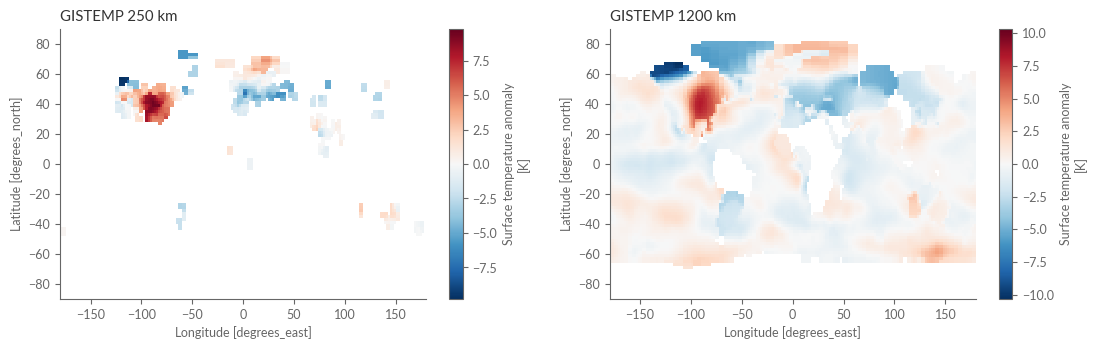

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 3.5))
gistemp_250.isel(time=0).plot(ax=axes[0])
gistemp_1200.isel(time=0).plot(ax=axes[1])
axes[0].set_title('GISTEMP 250 km')
axes[1].set_title('GISTEMP 1200 km')
plt.show()

##### HadCRUT5

The [HadCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html) dataset provided by the Met Office allows us to examine global climate anomalies and uncertainties. It includes:

- A gridded (mean) version
- A land-sea mask
- Individual ensemble members, which helps to understand model uncertainties.

1. **Download the Data**

On the website of HadCRUT5, you'll find two main versions:
1. HadCRUT5 analysis time series
2. HadCRUT5 analysis gridded data

Since we're interested in computing the time series ourselves in order to adapt them to our region of interest, we choose the gridded data. Let's copy the corresponding URLs and download the data:

In [61]:
url_hadcrut = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
url_hadcrut_weights = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.weights.nc'
url_hadcrut_ens_members = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/HadCRUT.5.0.1.0.analysis.anomalies.1_to_10_netcdf.zip'
urllib.request.urlretrieve(url_hadcrut, path_to['hadcrut'])
urllib.request.urlretrieve(url_hadcrut_weights, path_to['hadcrut_lsm'])
urllib.request.urlretrieve(url_hadcrut_ens_members, path_to['hadcrut_members'])

('data/hadcrut/temperature_hadcrut_ensemble_members.zip',
 <http.client.HTTPMessage at 0x7f9c05e605b0>)

2. **Unzip the Ensemble Members**

We'll need to extract the downloaded files:

In [18]:
with zipfile.ZipFile('data/hadcrut/temperature_hadcrut_ensemble_members.zip') as z:
    z.extractall('data/hadcrut/')

3. **Load and Organize the Data**

Load the datasets and streamline them for further analysis:

In [20]:
with xr.open_dataset(path_to["hadcrut"]) as hadcrut:
    pass
with xr.open_dataset(path_to["hadcrut_lsm"]) as hadcrut_weights:
    pass
hadcrut_members = xr.open_mfdataset("data/hadcrut/*analysis*.nc", combine="nested", concat_dim="realization")
hadcrut_members = hadcrut_members.load()  # load members into memory
hadcrut = xr.Dataset(
    {
        "mean": hadcrut["tas_mean"],
        "weights": hadcrut_weights["weights"],
        "ensemble": hadcrut_members["tas"],
    }
)
hadcrut = streamline_coords(hadcrut)
hadcrut

<xarray.Dataset>
Dimensions:      (time: 2082, lat: 36, lon: 72, realization: 10)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * realization  (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    mean         (time, lat, lon) float64 ...
    weights      (time, lat, lon) float64 ...
    ensemble     (realization, time, lat, lon) float64 nan nan ... 0.3561 0.3569

<div class="alert alert-block alert-warning">
<b>Note</b> <br>
    The <b>uncertainty estimation</b> doesn't consider the imprecision in the spatial mean due to limited spatial coverage. Be aware of this when interpreting the results, especially for early time periods.</a>
</div>



<div class="alert alert-block alert-info">
<b>Note</b> <br>
    The HadCRUT5 model has 200 ensemble members, but we're using only the first 20 here. While this reduces processing time, be aware that it may lead to an underestimation of uncertainty.</a>
</div>



##### ERA5 reanalysis

Now, we load ERA5 from the [Climate Data Store (CDS)](https://doi.org/10.24381/cds.f17050d7) using the `cdsapi`, including the land-sea mask. 

1. **Setup Your CDS API Key**

You'll need a specific key to access the CDS programmatically:

In [49]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################' # add your key here the format should be as {uid}:{api-key}

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

2. **Retrieve the Data**

Use the following code to pull the data from CDS:

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
  },
  path_to['era5']
)

Unlike other datasets, ERA5 provides temperatures in Kelvin. Convert them to Celsius for easier interpretation:

In [23]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    # convert from Kelvin to Celsius
    era5["t2m"] = era5["t2m"] - 273.15
era5 = streamline_coords(era5)
era5

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, time: 876)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
    lsm      (time, lat, lon) float32 dask.array<chunksize=(876, 27, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-18 21:45:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Calculation of Spatial Averages

In this section, we'll delve into the process of calculating spatial averages from different datasets, specifically accounting for two essential factors:

- **Longitude-Latitude Grid Representation**: The data is represented on a regular grid, which can lead to inflation of areas towards the poles.
- **Land Proportion Weighting**: When averaging over land, it's necessary to weigh the grid points according to the proportion of land in each cell.

These considerations are integral to accurately representing spatial patterns and trends. Here's how we'll proceed:

**Step 1: Define the Weighted Spatial Average Function**

First, we need a function that takes into account the above factors and can calculate the spatial average, even for subregions, by specifying a land-sea mask.

In [24]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Optionally, apply land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        # fill up nan values with 0 so that they don't affect the weighted mean
        land_mask = land_mask.fillna(0)
        # combine land mask with weights
        weights = weights * land_mask

    # Compute the weighted mean
    return da.weighted(weights).mean(("lat", "lon"))

**Step 2: Prepare Dictionaries for Datasets and Land-Sea Masks**

Before we can compute the averages, we need to define dictionaries that associate the data with the corresponding land-sea masks.

In [27]:
temps = {
    "HadCRUT": hadcrut["mean"],
    "HadCRUT_ensemble": hadcrut["ensemble"],
    "Berkeley": berkeley["temperature"],
    "GISTEMP": gistemp["tempanomaly"],
    "NOAA": noaa["anom"],
    "ERA5": era5["t2m"],
}
land_masks = {
    "HadCRUT": hadcrut["weights"],
    "HadCRUT_ensemble": hadcrut["weights"],
    "Berkeley": berkeley["land_mask"],
    "GISTEMP": gistemp["mask"],
    "NOAA": noaa["lsm"],
    "ERA5": era5["lsm"],
}

**Step 3: Iterate Over Datasets to Calculate Mean Temperatures**

Finally, we'll loop through our datasets and compute the mean temperatures for a specified `region`, such as the Arctic.

In [29]:
region = "Arctic"

temp_evolution = {}
for source in temps:
    spatial_average = weighted_spatial_average(
        temps[source], REGIONS[region], h
        temp_evolution[source] = spatial_average.compute()
temp_evolution = xr.Dataset(temp_evolution)
temp_evolution

[########################################] | 100% Completed | 118.59 s


<xarray.Dataset>
Dimensions:           (time: 2082, realization: 10)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-06-01
  * realization       (realization) int64 1 10 2 3 4 5 6 7 8 9
Data variables:
    HadCRUT           (time) float64 -1.962 -0.6203 -1.374 ... 2.094 2.331 1.309
    HadCRUT_ensemble  (realization, time) float64 -2.02 -0.3699 ... 2.168 1.19
    Berkeley          (time) float64 -1.055 0.07 0.6092 0.2195 ... nan nan nan
    GISTEMP           (time) float64 nan nan nan nan ... 2.965 2.102 2.159 1.558
    NOAA              (time) float64 -1.497 -0.4415 -1.032 ... 1.795 2.349 1.141
    ERA5              (time) float32 nan nan nan nan nan ... nan nan nan nan nan

<div class="alert alert-block alert-info">
<b>Note</b>: By changing the `region`, you can easily calculate averages for any other pre-defined region, allowing for versatile analysis and comparisons.
</div>

**Step 4: Aligning Datasets to a Common Reference Period**

Let's take note that while all datasets except ERA5 are already represented as anomalies, they have different reference periods. This means that we cannot directly compare them with each other. To align them, we'll calculate anomalies relative to the period 1991-2020.

In [30]:
# Show anomalies with respect to the 1991-2020 climatology
temp_evolution = temp_evolution - temp_evolution.sel(REF_PERIOD).mean("time")

**Step 5: Calculate Anomalies Relative to the Pre-Industrial Era**

Next, we'll analyze the temperature increase relative to the pre-industrial era, defined here as 1850-1900. We calculate the reference value as the average of the anomalies of all datasets within this time frame, excluding the HadCRUT ensemble members.

In [31]:
anom_1850_1900 = temp_evolution.drop_vars("HadCRUT_ensemble").sel(
    time=slice("1850", "1900")
)
mean_1850_1900 = anom_1850_1900.to_array().mean()
mean_1850_1900

**Step 6: Smooth the Time Series Data**

To provide a clearer picture, we'll calculate the 60-month (5-year) centered moving average of the time series. This helps reduce inter-annual climate fluctuations, such as those due to the El Niño-Southern Oscillation (ENSO).

In [32]:
temp_evolution_smooth = temp_evolution.rolling(time=60, center=True).mean()

**Step 7: Assess the Uncertainty of the HadCRUT Model**

Understanding uncertainty is crucial. Here, we calculate the confidence interval for the HadCRUT model as the minimum/maximum value of the ensemble members for each time step.

In [33]:
confidence_interval = temp_evolution_smooth["HadCRUT_ensemble"].quantile([0.0, 1.0], dim="realization")

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


**Et voilà! Visualization Time**

With the calculations complete, we're now ready to compare all the time series in a single graph. This will give us a comprehensive view of how temperature anomalies have evolved over different periods:

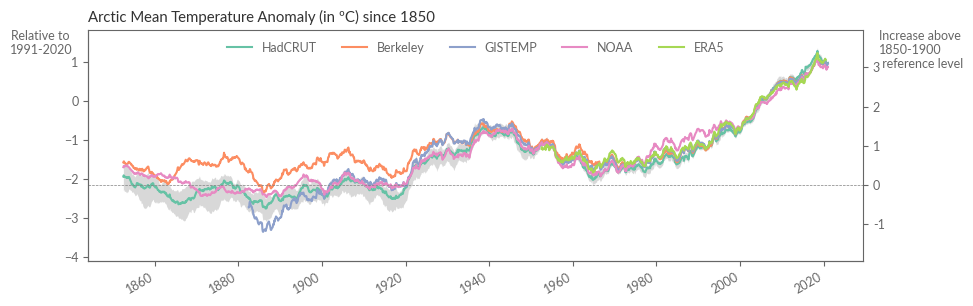

In [34]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
line_HadCRUT, = temp_evolution_smooth["HadCRUT"].plot(ax=ax, label="HadCRUT")
line_Berkeley, = temp_evolution_smooth["Berkeley"].plot(ax=ax, label="Berkeley")
line_GISTEMP, = temp_evolution_smooth["GISTEMP"].plot(ax=ax, label="GISTEMP")
line_NOAA, = temp_evolution_smooth["NOAA"].plot(ax=ax, label="NOAA")
line_ERA5, = temp_evolution_smooth["ERA5"].plot(ax=ax, label="ERA5")
area_HadCRUT = ax.fill_between(
    confidence_interval.time,
    confidence_interval.sel(quantile=0.0),
    confidence_interval.sel(quantile=1.0),
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], # same color (1st in the order) as the mean data from the same dataset (HadCRUT)
    alpha=0.3,
    lw=0,
    zorder=-1,
)

ax.legend(
    [(line_HadCRUT, area_HadCRUT), # add in the same handle the line and patch for the HadCRUT mean and ensembles
      line_Berkeley, line_GISTEMP, line_NOAA, line_ERA5], 
    ['HadCRUT', 'Berkeley', 'GISTEMP', 'NOAA', 'ERA5'],
    ncols=5, frameon=False, loc="upper center"\
    )


ax2.spines["right"].set_visible(True)
ax2.spines["top"].set_visible(True)
ax.xaxis.set_major_locator(mdates.YearLocator(20))

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title(f"{region} Mean Temperature Anomaly (in ºC) since 1850")
ax.text(
    -0.02,
    1,
    "Relative to \n1991-2020",
    rotation=0,
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    1,
    "Increase above \n1850-1900\n reference level",
    rotation=0,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.axhline(mean_1850_1900, color=".5", lw=0.5, ls="--")

yticks = np.arange(-10, 10, 1)
ax2_yticks = yticks + mean_1850_1900.item()
ax2.set_yticks(ax2_yticks)
ax2.set_yticklabels(yticks)
ax.set_ylim(-4.1, 1.8)
ax2.set_ylim(-4.1, 1.8)

plt.show()

#### Understanding Model Discrepancies

Let's kick off by observing that datasets from the mid-last century onwards generally exhibit a **high degree of agreement**. But to truly quantify this, we're going to calculate the spread, which is the range between the highest and lowest values for each time point. Note how the differences between datasets tend to grow as we delve further back in time.

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


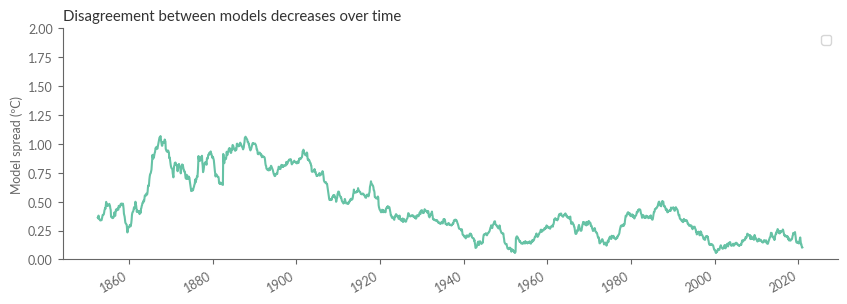

In [35]:
qs = temp_evolution_smooth.drop_vars(["HadCRUT_ensemble"]).to_array().quantile([0, 1], 'variable')
plt.figure(figsize=(10, 3))
qs.diff('quantile').plot.line(x='time', add_legend=False)
plt.ylim(0, 2.0)
plt.ylabel("Model spread (ºC)")
plt.xlabel("")
plt.title("Disagreement between models decreases over time")
plt.show()

Why do these differences occur? There's a plethora of reasons, but one significant factor stands out: as we move further back in time, there were fewer observation stations, leading to limited spatial coverage. Let's illustrate this using **BerkeleyEarth** as our muse.

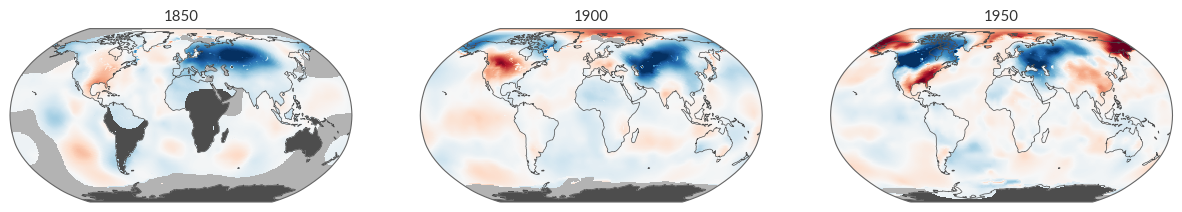

In [37]:
fig = plt.figure(figsize=(15, 5))
ax = [plt.subplot(1, 3, i+1, projection=ccrs.Robinson()) for i in range(3)]
kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-8, vmax=8, add_colorbar=False, zorder=3)
berkeley['temperature'].sel(time='1850-01').plot(ax=ax[0], **kwargs)
berkeley['temperature'].sel(time='1900-01').plot(ax=ax[1], **kwargs)
berkeley['temperature'].sel(time='1950-01').plot(ax=ax[2], **kwargs)
for a in ax:
    a.add_feature(cfeature.LAND, lw=.5, color='.3', zorder=1)
    a.add_feature(cfeature.OCEAN, lw=.5, color='.7', zorder=2)
    a.coastlines(lw=.5, color='.3', zorder=4)
    a.set_global()
    a.set_title('')
ax[0].set_title('1850', loc='center')
ax[1].set_title('1900', loc='center')
ax[2].set_title('1950', loc='center')
plt.show()

Reiterating an essential point: the uncertainty displayed for the HadCRUT model seems on the lower side. While a part of this can be attributed to a reduced ensemble size which we used here, another part stems from the limited spatial coverage at the beginning of the time series.

#### Wrapping Up with Earth's Temperature

Finally, we're going to address the burning question: Just how warm is our dear Earth?

By using absolute temperatures from **ERA5**, let’s compute the average temperature for the reference period (1991-2020) over a region of our choice.

In [40]:
# Taking Earth's mean temperature
region = "Arctic"  # <--- define the region here

land_mask = era5["lsm"]
clim_temp_era5 = era5["t2m"].sel(REF_PERIOD)  # consider the reference period
clim_temp_era5 = weighted_spatial_average(clim_temp_era5, REGIONS[region], land_mask=land_mask)

with ProgressBar():
    clim_temp_era5 = clim_temp_era5.compute()  # compute the result

[########################################] | 100% Completed | 95.00 s


Now that we have monthly anomalies for our reference period, computing the temporal average correctly requires to weight each month by the respective number of days. Let's do this:

In [41]:
days_in_month = clim_temp_era5.time.dt.days_in_month
clim_temp_era5 = (clim_temp_era5 * days_in_month).sum() / days_in_month.sum()

In [42]:
print(f'{region} mean temperature between 1991 and 2020 was {clim_temp_era5.item():.1f} °C.')

Arctic mean temperature between 1991 and 2020 was -12.7 °C.


#### In Retrospect...

And there you have it! From discerning Earth's surface temperature changes since 1850, grappling with an array of datasets using handy tools like `dask` and `regionmask`, to calculating weighted averages spatially and temporally, we've covered a lot of ground together.

In the [following part](https://ecmwfcode4earth.github.io/sketchbook-earth/02_temperature/02b_temperature.html), we focus on comparing ERA5 surface temperatures in Europe with observational data. 